In [1]:
import torch
from torchvision.transforms import transforms as T
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

from utils.datasets import LoadImagesAndLabels, collate_fn, JointDataset
from jde_rcnn import Jde_RCNN

import matplotlib.pyplot as plt
import cv2
import numpy as np

In [3]:
root = '..'
# paths = {'CT':'./data/CalTech.txt', 'CUHK':'./data/CUHK.txt', 
#          'ETH':'./data/ETH.txt', 'M16':'./data/MOT16_train.txt', 
#          'PRW':'./data/PRW.txt', 'CP':'./data/cp_train.txt'}
paths = {'M16':'./data/MOT16_train.txt'}
transforms = T.Compose([T.ToTensor()])
trainset = JointDataset(root=root, paths=paths, img_size=(576,320), augment=True, transforms=transforms)

dataset summary
OrderedDict([('M16', 125.0)])
total # identities: 126
start index
OrderedDict([('M16', 0)])


In [4]:
batch_size = 4
dataloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True,
                                             num_workers=8, pin_memory=True, drop_last=True, collate_fn=collate_fn)

In [2]:
backbone = resnet_fpn_backbone('resnet101', True)
backbone.out_channels = 256

model = Jde_RCNN(backbone, num_ID=1129)

In [5]:
for i, (name, p) in enumerate(model.roi_heads.named_parameters()):
    print(name, p.requires_grad)

s_c True
s_r True
s_id True
box_head.fc6.weight True
box_head.fc6.bias True
box_head.fc7.weight True
box_head.fc7.bias True
box_predictor.cls_score.weight True
box_predictor.cls_score.bias True
box_predictor.bbox_pred.weight True
box_predictor.bbox_pred.bias True
box_predictor.extract_embedding.weight True
box_predictor.extract_embedding.bias True
identifier.weight True
identifier.bias True


In [6]:
model.train()
for i, (imgs, labels, _, _, targets_len) in enumerate(dataloader):
    targets = []
    for target_len, label in zip(np.squeeze(targets_len), labels):
        target = {}
        target['boxes'] = label[0:int(target_len), 2:6]
        target['ids'] = (label[0:int(target_len), 1]).long()
        target['labels'] = torch.ones_like(target['ids'])
        targets.append(target)
    losses = model(imgs, targets)
    break

In [14]:
checkpoint = torch.load('../weights/trained/2/latest.pt', map_location='cpu')
model = torch.nn.DataParallel(model)
model.load_state_dict(checkpoint['model'])

<All keys matched successfully>

In [7]:
losses

{'loss_total': tensor([40.9497], grad_fn=<MulBackward0>),
 'loss_classifier': tensor(0.7050, grad_fn=<NllLossBackward>),
 'loss_box_reg': tensor(2.8830e-05, grad_fn=<DivBackward0>),
 'loss_reid': tensor(4.8601, grad_fn=<NllLossBackward>),
 'loss_objectness': tensor(0.6937, grad_fn=<BinaryCrossEntropyWithLogitsBackward>),
 'loss_rpn_box_reg': tensor(1.1660, grad_fn=<DivBackward0>)}

In [16]:
import json
log = {}
for key, val in losses.items():
    log[key] = float(val)
loss_log = [log, log]
loss_log

[{'loss_total': 41.55693435668945,
  'loss_classifier': 0.7223899364471436,
  'loss_box_reg': 6.445703911595047e-05,
  'loss_reid': 4.870730400085449,
  'loss_objectness': 0.6939731240272522,
  'loss_rpn_box_reg': 1.3480209112167358},
 {'loss_total': 41.55693435668945,
  'loss_classifier': 0.7223899364471436,
  'loss_box_reg': 6.445703911595047e-05,
  'loss_reid': 4.870730400085449,
  'loss_objectness': 0.6939731240272522,
  'loss_rpn_box_reg': 1.3480209112167358}]

In [17]:
path = './log/loss.json'
with open(path, 'w+') as file:
    json.dump(loss_log, file)

In [19]:
with open(path, 'r') as file:
    a = json.load(file)
a

[{'loss_total': 41.55693435668945,
  'loss_classifier': 0.7223899364471436,
  'loss_box_reg': 6.445703911595047e-05,
  'loss_reid': 4.870730400085449,
  'loss_objectness': 0.6939731240272522,
  'loss_rpn_box_reg': 1.3480209112167358},
 {'loss_total': 41.55693435668945,
  'loss_classifier': 0.7223899364471436,
  'loss_box_reg': 6.445703911595047e-05,
  'loss_reid': 4.870730400085449,
  'loss_objectness': 0.6939731240272522,
  'loss_rpn_box_reg': 1.3480209112167358}]

In [10]:
output = model(imgs)

In [11]:
output

4e+01, 1.7813e+02, 1.1766e+02]],
         grad_fn=<StackBackward>),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1]),
  'scores': tensor([0.5261, 0.5245, 0.5244, 0.5206, 0.5199, 0.5177, 0.5175, 0.5158, 0.5154,
          0.5152, 0.5143, 0.5138, 0.5135, 0.5134, 0.5128, 0.5121, 0.5115, 0.5113,
          0.5113, 0.5111, 0.5110, 0.5110, 0.5108, 0.5105, 0.5103, 0.5103, 0.5102,
          0.5097, 0.5097, 0.5094, 0.5093, 0.5093, 0.5092, 0.5089, 0.5083, 0.5082,
          0.5081, 0.5081, 0.5079, 0.5078, 0.5078, 0.5077, 0.5074, 0.5073, 0.5072,
          0.5072, 0.5072, 0.5070, 0.5069, 0.5068, 0.5063, 0.5063, 0.5062, 0.5062,
          0.5062, 0.5057, 0.5057, 0.5056, 0.5055, 0.5054, 0.5053, 0.

In [12]:
targets

[{'boxes': tensor([[627.6100, 282.9884, 697.1605, 420.0151],
          [680.7518, 336.8093, 793.1282, 670.9249],
          [452.6441, 237.1045, 489.2868, 332.7949],
          [756.6830, 325.2502, 853.2292, 641.0759]]),
  'labels': tensor([5431, 5438, 5439, 5440])},
 {'boxes': tensor([[857.9728, 213.5399, 899.3476, 311.3754],
          [834.7565, 240.8038, 855.8149, 288.2170],
          [722.4943, 242.4873, 764.1474, 344.0063],
          [754.2072, 240.8243, 772.7994, 289.7079],
          [662.7156, 236.8050, 682.1914, 285.8572],
          [642.9983, 243.0196, 659.3572, 284.6594]]),
  'labels': tensor([  -1, 5268, 5955, 5958, 5977, 5978])},
 {'boxes': tensor([[402.6331, 278.4064, 424.3565, 332.6671],
          [247.8774, 277.4247, 285.3545, 394.1044]]),
  'labels': tensor([5639, 5641])},
 {'boxes': tensor([[207.3439, 283.1440, 255.2859, 462.2130],
          [181.3599, 269.0020, 242.4666, 468.8777],
          [224.0699, 304.2478, 278.7894, 462.0604],
          [315.7787, 318.9307, 356.59

In [17]:
imgs.size()

torch.Size([16, 3, 608, 1088])

(480, 640, 3)

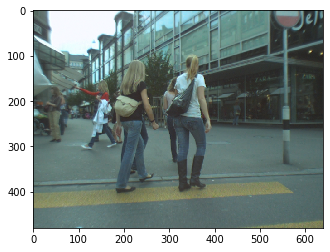

In [9]:
img = cv2.imread('./dataset/ETH/images/Linthescher/image_00002087_0.png')
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
img.shape

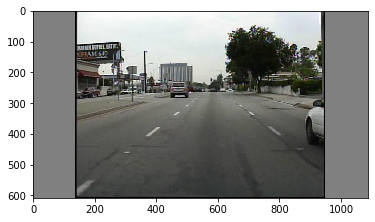

In [28]:
from utils.datasets import letterbox

img1, ratio, dw, dh = letterbox(img)
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))


[[  0.  -1. 136. 227.  32.  70.]
 [  0.  -1. 159. 220.  37.  76.]
 [  0.  -1. 237. 226.  34.  68.]
 [  0.  -1. 313. 223.  34.  78.]
 [  0.  -1. 365. 229.  36.  87.]
 [  0.  -1. 433. 230.  32.  77.]
 [  0.  -1. 456. 230.  32.  73.]
 [  0.  -1. 497. 235.  29.  72.]
 [  0.  -1. 521. 233.  42.  91.]]
[[ 0.00000000e+00 -1.00000000e+00  9.74185000e+04  1.16736000e+05
   1.23359836e+05  1.59296000e+05]
 [ 0.00000000e+00 -1.00000000e+00  1.14037172e+05  1.10656000e+05
   1.44031844e+05  1.56864000e+05]
 [ 0.00000000e+00 -1.00000000e+00  1.78485172e+05  1.16736000e+05
   2.06047844e+05  1.58080000e+05]
 [ 0.00000000e+00 -1.00000000e+00  2.40095844e+05  1.11872000e+05
   2.67658500e+05  1.59296000e+05]
 [ 0.00000000e+00 -1.00000000e+00  2.81439844e+05  1.12784000e+05
   3.10623844e+05  1.65680000e+05]
 [ 0.00000000e+00 -1.00000000e+00  3.38186500e+05  1.16432000e+05
   3.64127844e+05  1.63248000e+05]
 [ 0.00000000e+00 -1.00000000e+00  3.56831844e+05  1.17648000e+05
   3.82773188e+05  1.62032000e

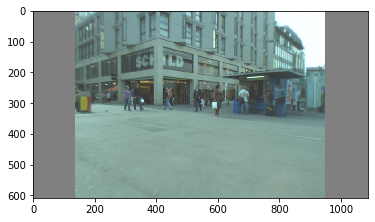

In [42]:
from utils.datasets import random_affine
import numpy as np
img_path = './dataset/ETH/images/Linthescher/image_00000930_0.png'
label_path = img_path.replace('images','images').replace('.png','.txt')
img = cv2.imread(img_path)
target = np.loadtxt(label_path, delimiter=',')
print(target)
h, w, _ = img.shape
img, ratio, padw, padh = letterbox(img)
if os.path.isfile(label_path):
    labels0 = np.loadtxt(label_path, delimiter=',', dtype=np.float32).reshape(-1, 6)

    # Normalized xywh to pixel xyxy format
    labels = labels0.copy()
    labels[:, 2] = ratio * w * (labels0[:, 2] - labels0[:, 4] / 2) + padw
    labels[:, 3] = ratio * h * (labels0[:, 3] - labels0[:, 5] / 2) + padh
    labels[:, 4] = ratio * w * (labels0[:, 2] + labels0[:, 4] / 2) + padw
    labels[:, 5] = ratio * h * (labels0[:, 3] + labels0[:, 5] / 2) + padh

plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
print(labels)

[]


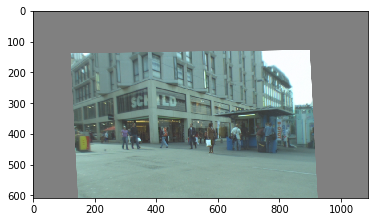

In [40]:
img1, labels1, M = random_affine(img, labels, degrees=(-5, 5), translate=(0.10, 0.10), scale=(0.50, 1.20))
plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
print(labels1)